In [42]:
import pandas as pd
import numpy as np

import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import requests
import pandas as pd
import datetime
import pytz
from skimage import io
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import os
import pandas as pd



from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, BatchNormalization, Flatten, Dropout, Dense, Conv1D, MaxPooling1D, BatchNormalization, GRU
import joblib 

In [59]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()

In [60]:
sensor_all = Dataset.Tabular.from_delimited_files(path=(default_ds, 'sensor-data/sensor_all.csv')).to_pandas_dataframe()
sensor_all_hum = Dataset.Tabular.from_delimited_files(path=(default_ds, 'sensor-data/sensor_all_hum.csv')).to_pandas_dataframe()
sensor_all_pre =  Dataset.Tabular.from_delimited_files(path=(default_ds, 'sensor-data/sensor_all_pre.csv')).to_pandas_dataframe()

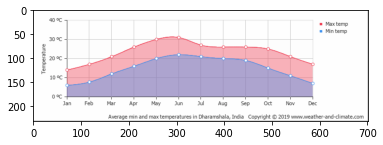

In [61]:
# This is a common climate pattern in this location,
# I will be dividing sequence into two, and build two models, at end of month may.


image = io.imread("https://weather-and-climate.com/uploads/average-temperature-india-dharamshala-in.png")
plt.imshow(image)
plt.show()

# https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine,raipur-chhattisgarh-in,India

In [62]:
class Analysis():
      def __init__(self):
          pass

      def test_stationary(self, y):
        """
            y : Time series
        """
        print('Results of Dickey-Fuller Test:')
        adfinput = adfuller(y)
        adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
        adftest = round(adftest, 4)

        for key, value in adfinput[4].items():
            adftest["Critical Value (%s)"%key] = value.round(4)

        print(adftest)

        if adftest[0].round(2) < adftest[5].round(2):
            print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe series seems to be stationary', adftest[0].round(2) , adftest[5].round(2))
        else:
            print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe series isn't stationary")

      def plot_rolling_data(self, timeseries):
          """
              y : Time series
          """
          rolmean = timeseries.rolling(24).mean()
          rolstd = timeseries.rolling(24).std() 
          #Plot rolling statistics:
          orig = plt.plot(timeseries, color='blue',label='Original')
          mean = plt.plot(rolmean, color='red', label='Rolling Mean')
          std = plt.plot(rolstd, color='black', label = 'Rolling Std')
          plt.legend(loc='best')
          plt.title('Mean & Standard Deviation')
          plt.show()
    

In [63]:
analysis = Analysis()

In [64]:
data = pd.DataFrame({"pre": sensor_all_pre.target, "hum": sensor_all_hum.target, "tc": sensor_all.target})

In [65]:
data.corr()
# temp has negative relation with pressure and humidity. and strong relation with humidity
# pressure and humidity are weakly related

,pre,hum,tc
pre,1.000000,0.118315,-0.513941
hum,0.118315,1.000000,-0.713010
tc,-0.513941,-0.713010,1.000000


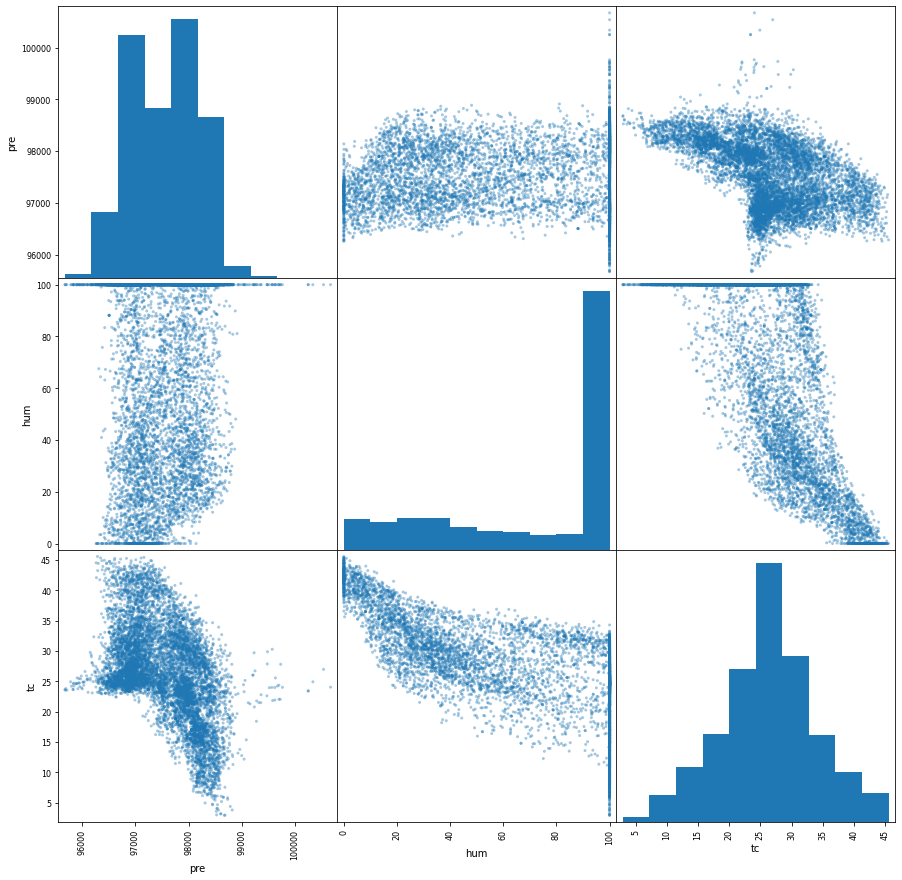

In [66]:
features_mean = data.columns
pd.plotting.scatter_matrix(data[features_mean], alpha=0.4, figsize=((15,15)));
plt.show()

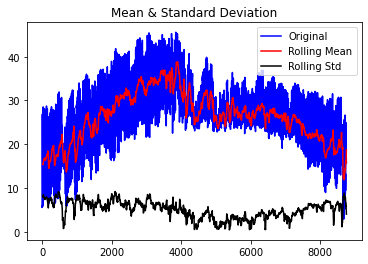

In [67]:
#
# Plot timeseries, and Rolling average
#

ts = sensor_all.target
analysis.plot_rolling_data(ts)

# After averaging 24 hours still their is a seasonal affect manualy checked it to be around 8 days.
# We can segregate into multiple series and the make models.

In [68]:
# values two is highly correlated
sensor_all.corr()

,Column1,target,value_one,value_two,month
Column1,1.000000,-0.050245,-0.299592,-0.144088,0.996501
target,-0.050245,1.000000,0.802216,0.924395,-0.047841
value_one,-0.299592,0.802216,1.000000,0.921679,-0.296221
value_two,-0.144088,0.924395,0.921679,1.000000,-0.141114
month,0.996501,-0.047841,-0.296221,-0.141114,1.000000


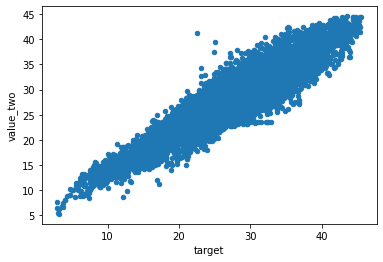

In [69]:
sensor_all.plot.scatter(x='target', y='value_two');

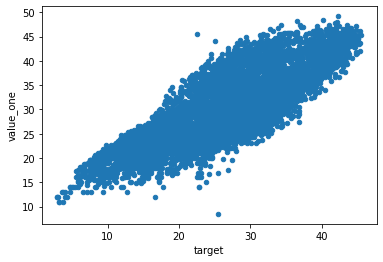

In [70]:
sensor_all.plot.scatter(x='target', y='value_one');

In [71]:
#
# Outlier detection and Removel
#

In [72]:
target = ['target', "value_one", "value_two"]
Q1 = sensor_all.quantile(0.25)
Q3 = sensor_all.quantile(0.75)
IQR = Q3 - Q1

In [73]:

sensor_all.loc[(sensor_all.target > (Q3.target + 1.5 * IQR.target)), "target"] = Q1.target
sensor_all.loc[(sensor_all.value_one < (Q1.value_one - 1.5 * IQR.value_one)), "value_one"] = Q1.value_one
sensor_all.loc[(sensor_all.value_two < (Q1.value_two - 1.5 * IQR.value_two)), "value_two"] = Q1.value_two

In [74]:
sensor_all.loc[(sensor_all.target < (Q1.target - 1.5 * IQR.target)), "target"] = Q3.target
sensor_all.loc[(sensor_all.value_one  > (Q3.value_one + 1.5 * IQR.value_one)), "value_one"] = Q3.value_one
sensor_all.loc[(sensor_all.value_two > (Q3.value_two + 1.5 * IQR.value_two)), "value_two"] = Q3.value_two

In [75]:
lb = MinMaxScaler()
sensor_all[target] = lb.fit_transform(sensor_all[target])
# Save for further usage
joblib.dump(lb, 'minmax.pkl') 

['minmax.pkl']

In [76]:
#
# Data preparation
#

In [77]:
# Prediction next 24 days
target_size = 24
# Based on past 7 days
seq_len = 24 * 7

data = list(sensor_all.target.values)

# The test strategy is to take random sequencys from all the data, Because their is only data for single months.
training_size = 0.2
total = len(data)

X_target = []
Y_target = []

for start in range(0, total - seq_len + target_size):
    #print(start, start + seq_len, start + seq_len, start + seq_len + target_size)
    X_target.append(data[start : start + seq_len])
    Y_target.append(data[start + seq_len: start + seq_len + target_size])

In [78]:
data = list(sensor_all.value_one.values)

X_value_one = []

for start in range(0, total - seq_len + target_size):
    X_value_one.append(data[start : start + seq_len])

In [51]:
data = list(sensor_all.value_two.values)

X_value_two = []

for start in range(0, total - seq_len + target_size):
    X_value_two.append(data[start : start + seq_len])

In [52]:
# list to array. 
# To.Do: this may not probabily right way :-P.

X_value_two = pd.DataFrame(X_value_two).values[:-seq_len]
X_value_one = pd.DataFrame(X_value_one).values[:-seq_len]
X_target = pd.DataFrame(X_target).values[:-seq_len]
Y_target = pd.DataFrame(Y_target).values[:-seq_len ]

In [53]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, indx, indy = train_test_split(X_target, Y_target, list(range(len(Y_target))), test_size=training_size, random_state=0)

In [54]:

x_train1, x_train2 = X_value_one[indx], X_value_two[indx]
x_test1, x_test2 = X_value_one[indy], X_value_two[indy]

In [55]:
# Further Improvement: By  stacking source two sequences and run a convolution on it, so that avg will be used to make final predection.

inputs = keras.Input(shape=(seq_len, 1), name="target")
inputs1 = keras.Input(shape=(seq_len, 1), name="target2")


x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False))(inputs)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False))(inputs1)

flatten = tf.keras.layers.Flatten()
x = tf.keras.layers.Concatenate()([flatten(x), flatten(x1)])

x = tf.keras.layers.Dense(50)(x)
outputs = tf.keras.layers.Dense(target_size)(x)

model = keras.Model(inputs =  [inputs, inputs1],outputs= outputs, name="test")
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()])

In [57]:

# model.fit({"target": x_train, "target2": x_train2}, y_train , validation_data=( {"target": x_test, "target2": x_test2}, y_test) , batch_size=10, epochs=50, verbose=1)

In [ ]:
i = 106
x = list(x_test[i])
y = list(model.predict({"target": x_train, "target2": x_train2})[i])
z = list(y_test[i])

In [ ]:
plt.figure()
plt.plot(x + y, '-r', label='Predection Future')
plt.plot(x + z, '-b', label='Actual Future')
plt.legend()
plt.show()